In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from recalibration_utils import *
from session_utils import *
from hmm_utils import prep_HMMData

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

min_nblocks    = 3

fig_path       = 'C:/Users/ghwilson/Box/GuyWilson_Files/nonstationarities_project/paper_figures/figures/'
filelist       = glob.glob('D:/T5_ClosedLoop/historical/*')
sessions_check = np.load('misc_data/OldSessions_check.npy', allow_pickle = True).item()
files          = get_Sessions(filelist, min_nblocks,  manually_remove = sessions_check['bad_days'])
n_files        = len(files)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Do some RT and target dwell period characterizations

For a linear decoder with outputs $ u_{t} \in \mathbb{R}^{2} $, and a correct unit-norm point-at-target vector $p_{t}$, we can model:

  $u_{t} = \alpha p_{t} + N(0, \sigma^{2}) $

and define $SNR = \alpha / \sigma $. To model this effectively we chop out:

- RT interval - when participant is not yet using the decoder  (we'll determine this below)
- near target - where outputs can vary quickly with respect to $p_{t}$  (we determine this in *behavior_clicks.ipynb*)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<ipython-input-147-d3279cfa6ca8>:24: RuntimeWarning: invalid value encountered in true_divide
  _ = plt

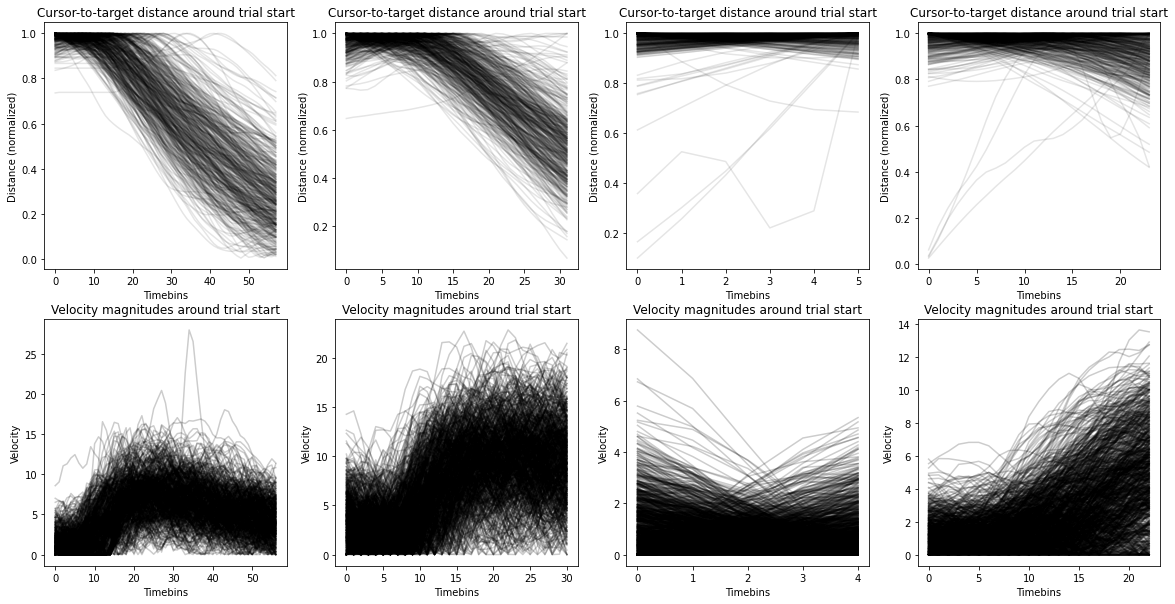

In [147]:
figSize(10, 20)

np.random.seed(42)
diffs           = list()
task            = 'cursor'



for i, f in enumerate(np.random.choice(files, 4, replace = False)):
    dat       = DataStruct(f, alignScreens = True)
   # blocks    = [sessions_check[f] if  f in sessions_check.keys() else None][0]
    
    _, cursorPos, targPos = getNeuralCursorTarget(dat, task = task)
    
    cursorPos = np.concatenate(cursorPos)
    targPos   = np.concatenate(targPos)
    cursorErr = [targ - cur for targ, cur in zip(targPos, cursorPos)]
    
    minlen     = np.min([cursorErr[i].shape[0] for i in range(len(cursorErrs))])
    starts     = np.dstack([cursorErr[i][:minlen, :] for i in range(len(cursorErrs))])
    dists      = np.linalg.norm(starts, axis = 1)

    plt.subplot(2, 4, i + 1)
    _ = plt.plot(dists / dists.max(axis = 0), color = 'k', alpha = 0.1)
    plt.ylabel('Distance (normalized)')
    plt.xlabel('Timebins')
    plt.title('Cursor-to-target distance around trial start')
    
    minlen     = np.min([cursorPos[i].shape[0] for i in range(len(cursorPos))])
    velocities = [np.diff(cursorPos[i][:minlen, :], axis = 0) for i in range(len(cursorPos))]
    magnitudes = [np.linalg.norm(velocities[i], axis = 1) for i in range(len(cursorPos))]
    
    plt.subplot(2, 4, i + 5)
    for trl in magnitudes:
        plt.plot(trl - trl.min(), color = 'k', alpha = 0.2)
        
    plt.ylabel('Velocity')
    plt.xlabel('Timebins')
    plt.title('Velocity magnitudes around trial start')

    

In [156]:
len(train_cursorPos)

524

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested seq

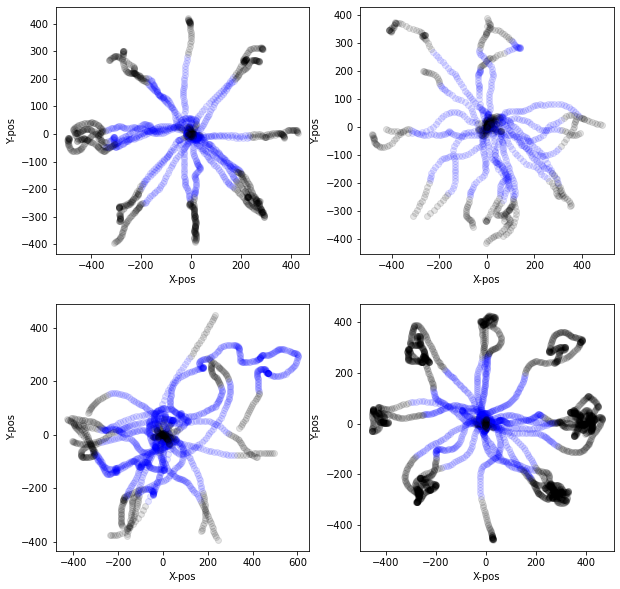

In [3]:
from metrics import estimateSNR
figSize(10, 10)

# general settings:
np.random.seed(42)
diffs           = list()
task            = 'cursor'
train_size      = 0.67
sigma           = None
n_plot          = 20   # number of reach trajectories to plot 

# SNR calculation settings:
thresh          = 150  # only calculate SNR using points far from target
cutStart        = 10   # exclude first 10 timesteps (200 ms to account for RT)

for i, f in enumerate(np.random.choice(files, 4, replace = False)):
    dat       = DataStruct(f, alignScreens = True)
   # blocks    = [sessions_check[f] if  f in sessions_check.keys() else None][0]
    
    train_x, test_x, train_y, test_y, train_cursorPos, test_cursorPos = getTrainTest(dat, train_size, task = task, blocks = None, sigma = sigma, 
                                                                                    returnCursor = True, returnFlattened = False)
    # combine across blocks
    train_x = np.concatenate(train_x)
    test_x  = np.concatenate(test_x)
    train_y = np.concatenate(train_y)
    test_y  = np.concatenate(test_y)
    train_cursorPos = np.concatenate(train_cursorPos)
    test_cursorPos  = np.concatenate(test_cursorPos)
    
    
    n_trls       = len(train_x)
    input_neural = np.vstack(train_x)
    input_cursor = np.vstack(train_cursorPos)
    input_target = np.vstack(train_y) + input_cursor
    input_starts = np.cumsum([x.shape[0] for x in train_x])
    
    _, usedIdx = estimateSNR(input_neural, input_cursor, input_target, input_starts, minDist = thresh, cutStart = cutStart)
    
    plt.subplot(2, 2, i + 1)
    plt.xlabel('X-pos')
    plt.ylabel('Y-pos')
    for j in np.random.choice(n_trls, n_plot, replace = False):
        start      = input_starts[j]
        stop       = input_starts[j + 1] - 1
        targ       = input_target[stop, :] 
        trl_cursor = input_cursor[start:stop, :] - input_cursor[start, :]
        
        used       = np.in1d(np.arange(start, stop), usedIdx) 
        unused     = ~ used
        
        _ = plt.scatter(trl_cursor[used, 0], trl_cursor[used, 1], color = 'b', alpha = 0.1)
        _ = plt.scatter(trl_cursor[unused, 0], trl_cursor[unused, 1], color = 'k', alpha = 0.1)
       # plt.scatter(targ[0], targ[1], color = 'k')

plt.savefig(fig_path + 'SNR/T5_exampleTrialsColored', format = 'pdf')

In [4]:

# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_size      = 0.5
sigma           = None

# SNR calculation settings:
thresh          = 300  # only calculate SNR using points far from target
cutStart        = 10   # exclude first 10 timesteps (200 ms to account for RT)

SNRs   = list()
scores = list()
for i, session in enumerate(files):  
    dat       = DataStruct(session, alignScreens = True)
    blocks    = [sessions_check[session] if  session in sessions_check.keys() else None][0]

    train_x, test_x, train_y, test_y, train_cursorPos, test_cursorPos = getTrainTest(dat, train_size, task = task, blocks = None, sigma = sigma, returnCursor = True, returnFlattened = True)
    # run function again to get individual trials so we can see lengths (inefficient/lazy):
    indiv_trls = np.concatenate(getTrainTest(dat, train_size, task = task, blocks = None, sigma = sigma, returnCursor = True, returnFlattened = False)[0]) 
    
    # blockwise subtraction:
    train_x, test_x = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)

    # combine other trial data across blocks:
    train_y      = np.concatenate(train_y)
    test_y       = np.concatenate(test_y)
    train_cursor = np.concatenate(train_cursorPos)
    train_target = train_y + train_cursor
    train_starts = np.cumsum([x.shape[0] for x in indiv_trls])
    
    SNR, usedIdx = estimateSNR(train_x, train_cursor, train_target, train_starts, minDist = thresh, cutStart = cutStart)
    lm           = LinearRegression().fit(train_x, train_y)
    scores.append( lm.score(test_x, test_y) )
    SNRs.append(SNR)
    
    
    if (i + 1) % 20 == 0:
        print(i+1, '/', len(files), ' complete.')

SNRs = np.asarray(SNRs)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested seq

20 / 61  complete.


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested seq

40 / 61  complete.


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested seq

60 / 61  complete.


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(0.45198856864575165, 3.3982495442853766)
Median SNR:  1.5328126747767856


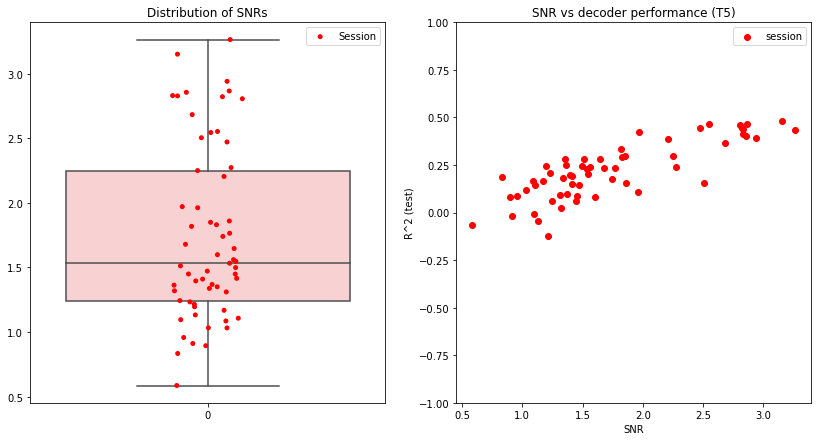

In [6]:
import seaborn as sns
figSize(7, 14)


plt.subplot(1, 2, 1)
plt.title('Distribution of SNRs')
sns.boxplot(data = SNRs, orient = 'v', color = 'r')
ax = plt.gca()
modifyBoxPlotAlpha(ax, 0.2)
sns.stripplot(data = SNRs, orient = 'v', color = 'r', label = 'Session', jitter = 0.1)
plt.legend()
print(plt.ylim())
#plt.violinplot(SNRs)

plt.subplot(1,2,2)
plt.scatter(SNRs, scores, label = 'session', color = 'r')
plt.ylim(-1, 1)
plt.legend()
plt.xlabel('SNR')
plt.ylabel('R^2 (test)')
plt.title('SNR vs decoder performance (T5)')
print('Median SNR: ', np.median(SNRs))

plt.savefig(fig_path + 'SNR/T5_SNR', format = 'pdf')